# Preamble

In [1]:
!pip install torch --quiet
!pip install torchvision --quiet
!pip install matplotlib --quiet
!pip install keras --quiet

In [2]:
import torch
from torch import nn
import torchvision
from typing import List
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from time import time
import numpy as np
import os
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Subset
import types
from tqdm import tqdm
import random
import itertools
import math
from scipy.ndimage.filters import gaussian_filter1d

In [3]:
xmode Context

Exception reporting mode: Context


In [4]:
# Use already computed results (fast, but you have to trust the results) or recalculate them from scratch (slow, takes several days)
recompute = False

# Save and Load data

In [5]:
data_dir = "Results"

In [6]:
class Stats:
  stats = ["losses", "communications", "train_losses", "train_accuracies", "test_losses", "test_accuracies", "true_iters", "times"]

  def __init__(self, name, stats_map):
    self.name = name
    assert len(stats_map) == len(Stats.stats)
    for stat in Stats.stats:
      self.__dict__[stat] = stats_map[stat]
  
  @staticmethod
  def new(name):
    return Stats(name, {stat:[] for stat in Stats.stats})

  @staticmethod
  def dir_name(name):
    return os.path.join(data_dir, name)

  def git_dir(self):
    return self.name

  def save(self):
    dir = Stats.dir_name(self.name)
    git_dir = self.git_dir()
    os.makedirs(dir, exist_ok=True) 
    for stat in Stats.stats:
      if not isinstance(self.__dict__[stat], np.ndarray):
        assert isinstance(self.__dict__[stat], list)
        self.__dict__[stat] = np.array(self.__dict__[stat], dtype=np.float32)
      np.save(os.path.join(dir, stat), self.__dict__[stat])

  @staticmethod
  def load(name):
    dir = Stats.dir_name(name)
    stats_map = {}
    for stat in Stats.stats:
      file_name = os.path.join(dir, stat)
      stats_map[stat] = np.load(file_name + ".npy")
    return Stats(name, stats_map)

# Data

In [7]:
num_load_workers = 0 # Change it to the number of workers if you would like to have parallel load
batch_size_train = 100
batch_size_test = 1000

random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

In [8]:
def split_into_classes(ds, mixing_rate, batch_size, num_classes=10):
  class2indices = [[] for _ in range(num_classes)]
  for i, y in enumerate(ds.targets):
    cls = y if random.random() > mixing_rate else random.randint(0, num_classes - 1)
    class2indices[cls].append(i)

  datasets = [Subset(ds, indices) for indices in class2indices]
  return [DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=num_load_workers) for ds in datasets]

## MNIST

In [9]:
mnist_transofrm = transform=torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train_ds = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=mnist_transofrm)
mnist_test_ds = torchvision.datasets.MNIST('/files/', train=False, download=True, transform=mnist_transofrm)

mnist_full_train_loader = DataLoader(mnist_train_ds,batch_size=batch_size_test, shuffle=True, num_workers=num_load_workers)
mnist_test_loader = DataLoader(mnist_test_ds, batch_size=batch_size_test, shuffle=True, num_workers=num_load_workers)

def mnist_federated_loader(mixing_rate):
  return split_into_classes(mnist_train_ds, mixing_rate, batch_size_train)

## Fashion-MNIST

In [10]:
fashion_transofrm = transform=torchvision.transforms.Compose([
  torchvision.transforms.ToTensor()
])

fashion_train_ds = torchvision.datasets.FashionMNIST('/files/', train=True, download=True, transform=fashion_transofrm)
fashion_test_ds = torchvision.datasets.FashionMNIST('/files/', train=False, download=True, transform=fashion_transofrm)

fashion_full_train_loader = DataLoader(fashion_train_ds,batch_size=batch_size_test, shuffle=True, num_workers=num_load_workers)
fashion_test_loader = DataLoader(fashion_test_ds, batch_size=batch_size_test, shuffle=True, num_workers=num_load_workers)

def fashion_federated_loader(mixing_rate):
  return split_into_classes(fashion_train_ds, mixing_rate, batch_size_train)

## CIFAR

In [11]:
cifar_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar_train_ds = torchvision.datasets.CIFAR10('/files/', train=True, transform=cifar_transform_train, download=True)
cifar_test_ds = torchvision.datasets.CIFAR10('/files/', train=False, transform=cifar_transform_test, download=True)

cifar_full_train_loader = DataLoader(cifar_train_ds, batch_size=batch_size_test, shuffle=True, num_workers=num_load_workers)
cifar_test_loader = DataLoader(cifar_test_ds, batch_size=batch_size_test, shuffle=False, num_workers=num_load_workers)

def cifar_federated_loader(mixing_rate):
  return split_into_classes(cifar_train_ds, mixing_rate, batch_size_train)

Files already downloaded and verified
Files already downloaded and verified


# Models

In [12]:
device = torch.device("cuda")
cpu = torch.device("cpu")

In [13]:
def dense_model(layers: List[int]):
  nnLayers = [nn.Flatten()]
  for i in range(len(layers) - 2):
    nnLayers.append(nn.Linear(layers[i], layers[i+1]))
    nnLayers.append(nn.ReLU())
  nnLayers.append(nn.Linear(layers[-2], layers[-1]))
  model = nn.Sequential(*nnLayers).to(device)
  model.train()
  return model

In [14]:
def disable_batch_norm(model):
  def replace_bn(module):
    children = [name for name, _ in module.named_children()]
    for child in children:
      target_attr = getattr(module, child)
      if isinstance(target_attr, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.LayerNorm)):
        setattr(module, child, nn.Identity())

    for name, child in module.named_children():
      replace_bn(child)

  replace_bn(model)
  return model

## MNIST

In [15]:
def conv_model(num_classes):
  layer1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
  layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
  flatten = nn.Flatten()
  fc = nn.Linear(7*7*32, num_classes)
  
  model = nn.Sequential(
        layer1,
        layer2,
        flatten,
        fc
    ).to(device)
  
  model.train()
  return model

In [16]:
class MnistResNet(torchvision.models.resnet.ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)

def mnist_resnet_model():
  model = MnistResNet().to(device)
  model.train()
  return model

## CIFAR

In [17]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2]).to(device)


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3]).to(device)


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3]).to(device)


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3]).to(device)


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3]).to(device)

In [18]:
def cifar_densenet_model():
  model = torchvision.models.densenet161().to(device)
  model.train()
  return model

In [19]:
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def vgg_make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def cifar_vgg_model():
  model = VGG(vgg_make_layers([64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'])).to(device)
  model.train()
  return model

In [20]:
class CifarConv(nn.Module):
    def __init__(self, num_classes=10):
        super(CifarConv, self).__init__()
        self.net = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Flatten(),
          nn.Linear(128 * 4 *4, num_classes),
        )

    def forward(self, x):
      return self.net(x)


def cifar_conv_model():
  model = CifarConv().to(device)
  model.train()
  return model

# Computation/Communication Strategies

In [21]:
class Full:
  def __init__(self, num_classes, gap):
    self.num_classes = num_classes
    self.gap = gap
  
  def generate(self):
    for i in itertools.count():
      if i % self.gap == 0:
        yield list(range(self.num_classes))
      else:
        yield []

In [22]:
class RoundRobin:
  def __init__(self, num_classes, classes_per_iteration, gap):
    self.num_classes = num_classes
    self.gap = gap
    self.classes_per_iteration = classes_per_iteration
  
  def generate(self):
    cur = 0
    for i in itertools.count():
      if i % self.gap == 0:
        res = []
        for _ in range(self.classes_per_iteration):
          res.append(cur)
          cur = (cur + 1) % self.num_classes
        yield res
      else:
        yield []

In [23]:
class Random:
  def __init__(self, num_classes, prob):
    self.num_classes = num_classes
    self.prob = prob
  
  def generate(self):
    cur = 0
    for _ in itertools.count():
      res = []
      for cls in range(self.num_classes):
        if random.random() < self.prob:
          res.append(cls)
      yield res

In [24]:
class DecrFreq:
  def __init__(self, num_classes):
    self.num_classes = num_classes
  
  def generate(self):
    cur = 0
    for i in itertools.count():
      res = []
      for cls in range(self.num_classes):
        if i % (cls + 1) == 0:
          res.append(cls)
      yield res

In [25]:
class IncrFreq:
  def __init__(self, num_classes):
    self.num_classes = num_classes
  
  def generate(self):
    cur = 0
    for i in itertools.count():
      res = []
      for cls in range(self.num_classes):
        if i % (self.num_classes - cls) == 0:
          res.append(cls)
      yield res

# Training

## Communication Helpers

In [26]:
def no_nan(tensor):
  return not torch.isnan(tensor).any()

In [27]:
def copy_state_dict(dict):
  return {k: v.detach().clone() for k, v in dict.items()}

In [28]:
def get_bn_distr(dict, param_pref):
  return [dict[param_pref + suf] for suf in ("running_mean", "running_var", "num_batches_tracked")]

In [29]:
def add_distr(distr1, distr2):
  mean1, var1, cnt1 = distr1
  mean2, var2, cnt2 = distr2
  cnt = cnt1 + cnt2
  assert cnt.item() > 0
  if cnt1.item() == 0:
    return distr2
  if cnt2.item() == 0:
    return distr1
  mean = (cnt1 * mean1 + cnt2 * mean2) / cnt
  var = (cnt1 * ((mean1 - mean)**2 + var1) + cnt2 * ((mean2 - mean)**2 + var2)) / cnt
  assert no_nan(mean)
  assert no_nan(var)
  assert (var >= 0).all(), str(torch.min(var))
  return [mean, var, cnt]

In [30]:
def subtract_distr(distr, distr2):
  mean, var, cnt = distr
  mean2, var2, cnt2 = distr2
  cnt1 = cnt - cnt2
  assert cnt1.item() > 0
  if cnt2.item() == 0:
    return distr
  mean1 = (cnt * mean - cnt2 * mean2) / cnt1
  var1 = (cnt * var  - cnt2 * ((mean2 - mean)**2 + var2)) / cnt1 - (mean1 - mean)**2
  assert no_nan(mean1)
  assert no_nan(var1)
  assert (var1 >= 0).all(), str(torch.min(var1))
  return [mean1, var1, cnt1]

In [31]:
def server_update(server_dict, client_model, prev_client_state_dict, bn_strategy, update_cnt, iter_cnt, n_machines):
  assert bn_strategy in ["noBN", "BN", "fixBN"], "Unexpected BN strategy: " + bn_strategy
  assert update_cnt > 0

  local_state_dict = client_model.state_dict()
  if bn_strategy in ["noBN", "BN"]:
    for k in server_dict.keys():
      server_dict[k] += (local_state_dict[k].detach() - prev_client_state_dict[k].detach()) / n_machines
  else:
    trigger = "running_mean"
    bn_prefixes = [k.replace(trigger, '') for k in server_dict.keys()
                                          if trigger in k]

    bn_params = {pref + suf for pref in bn_prefixes
                            for suf in ("running_mean", "running_var", "num_batches_tracked")}

    no_bn_params = [k for k in server_dict.keys()
                      if k not in bn_params]

    for k in no_bn_params:
      server_dict[k] += (local_state_dict[k].detach() - prev_client_state_dict[k].detach()) * (iter_cnt / update_cnt / n_machines)
    
    for pref in bn_prefixes:
      new_distr = get_bn_distr(local_state_dict, pref)
      assert iter_cnt == update_cnt

      server_distr = get_bn_distr(server_dict, pref)
      mean, var, cnt = add_distr(server_distr, new_distr)
      server_dict[pref + "running_mean"] = mean
      server_dict[pref + "running_var"] = var
      server_dict[pref + "num_batches_tracked"] = max(server_distr[2], new_distr[2])

## Evaluation

In [32]:
criterion = nn.CrossEntropyLoss()

def compute_loss_and_outputs(model, batch, labels):
  output = model(batch.to(device))
  return criterion(output, labels.to(device)), output

In [33]:
def true_results(model, data_loader, frac):
  total_loss = 0
  lim = int(math.ceil(len(data_loader) * frac))
  total_len = 0
  correct = 0
  for sample in itertools.islice(data_loader, lim):
    batch, labels = sample
    cur_len = len(labels)
    total_len += cur_len
    loss, outputs = compute_loss_and_outputs(model, batch, labels)
    _, predicted = torch.max(outputs, 1)
    correct += (predicted.to(cpu) == labels).sum().item()
    loss *= cur_len
    total_loss += loss.item()

  return total_loss / total_len, 100 * correct / total_len, total_len

In [34]:
def epoch_summary(model, fed_loaders, test_loader, full_train_loader, frac, stats):
  with torch.no_grad():
    iter = len(stats.losses)
    full_train_loss, full_train_acc, full_train_len = true_results(model, full_train_loader, frac)
    test_loss, test_acc, test_len = true_results(model, test_loader, frac)

  stats.true_iters += [iter]
  stats.train_losses += [full_train_loss]
  stats.train_accuracies += [full_train_acc]
  stats.test_losses += [test_loss]
  stats.test_accuracies += [test_acc]
  print("TrainLoss: {:.4f} TrainAcc: {:.2f} TestLoss: {:.4f} TestAcc: {:.2f}".format(
        full_train_loss, full_train_acc, test_loss, test_acc
        ), flush=True)

## Training Functions

In [35]:
def step(model, optimizer, batch, labels):
  optimizer.zero_grad()
  loss, _ = compute_loss_and_outputs(model, batch, labels)
  loss.backward()
  optimizer.step()
  return loss

In [36]:
def train(*, model_fn, fed_loaders, test_loader, full_train_loader, comp_strategy, comm_strategy, bn_strategy, learning_rate, epochs, stats):
  assert len(stats.losses) == 0

  n_machines = len(fed_loaders)
  print("Data Lengths:", [len(fl) for fl in fed_loaders])
  epoch_size = min(len(fl) for fl in fed_loaders)
  server_model = model_fn()
  server_state_dict = server_model.state_dict()

  assert bn_strategy in ["noBN", "BN", "fixBN"]
  if bn_strategy in ["noBN", "BN"]:
    for k in server_state_dict:
      if server_state_dict[k].dtype == torch.long:
        assert "num_batches_tracked" in k, "Can't handle parameter " + k
      server_state_dict[k] = server_state_dict[k].float()
  

  prev_client_state_dicts = [copy_state_dict(server_state_dict) for _ in range(n_machines)]
  client_models = [model_fn() for _ in range(n_machines)]
  update_cnt = [0] * n_machines
  last_comm = [-1] * n_machines
  total_comm = 0
  optimizers = []
  for model in client_models:
    model.load_state_dict(copy_state_dict(server_state_dict))
    model.train()
    optimizers.append(torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4))
    # optimizers.append(torch.optim.SGD(model.parameters(), lr=learning_rate))
  
  server_model.eval()

  start_time = time()
  iteration = -1
  for epoch in range(epochs):
    # server_model.load_state_dict(server_state_dict)
    epoch_summary(server_model, fed_loaders, test_loader, full_train_loader, 0.099, stats)
    progress_bar = tqdm(range(epoch_size), position=0, leave=True, miniters=10)
    data_loaders = [iter(fl) for fl in fed_loaders]
    
    full_losses = 0
    for i in progress_bar:
      iteration += 1
      loss, cur_machine_cnt = 0, 0
      # for machine in next(comp_strategy):
      for machine in range(n_machines):
        training_sample = next(data_loaders[machine])
        batch, labels = training_sample
        loss += step(client_models[machine], optimizers[machine], batch, labels)
        update_cnt[machine] += 1
        cur_machine_cnt += 1

      stats.losses += [stats.losses[-1] if cur_machine_cnt == 0 else loss / cur_machine_cnt]

      comm_machines = next(comm_strategy)

      for machine in comm_machines:
        if update_cnt[machine] > 0:
          server_update(server_state_dict, client_models[machine], prev_client_state_dicts[machine], bn_strategy,
                        update_cnt=update_cnt[machine], iter_cnt=iteration - last_comm[machine], n_machines=n_machines)
          last_comm[machine] = iteration
          update_cnt[machine] = 0
          total_comm += 1


      server_model.load_state_dict(server_state_dict)
      for k, v in server_state_dict.items():
        assert no_nan(v), k + " has nan:" + str(v)

      for machine in comm_machines:
        prev_client_state_dicts[machine] = copy_state_dict(server_state_dict)
        client_models[machine].load_state_dict(prev_client_state_dicts[machine])
        total_comm += 1
        # optimizers[machine] = torch.optim.SGD(client_models[machine].parameters(), lr=learning_rate, weight_decay=1e-4)

      stats.communications += [total_comm]
      stats.times += [time() - start_time]

      full_losses += stats.losses[-1]

      progress_bar.set_description(
          "{:2} {:3} Loss: {:.4f} Communication: {:5d} Time: {:.2f}".format(
              epoch,
              i, 
              full_losses / (i + 1),
              stats.communications[-1],
              stats.times[-1],
          ), refresh=False)
        
  # server_model.load_state_dict(server_state_dict)
  epoch_summary(server_model, fed_loaders, test_loader, full_train_loader, 1, stats)

## Arg Parser

In [37]:
def get_dataset(ds_name, mixing_rate):
  dataset_map = {
      "mnist":   lambda: (mnist_federated_loader(mixing_rate), mnist_test_loader, mnist_full_train_loader),
      "fashion": lambda: (fashion_federated_loader(mixing_rate), fashion_test_loader, fashion_full_train_loader),
      "cifar":   lambda: (cifar_federated_loader(mixing_rate), cifar_test_loader, cifar_full_train_loader),
      "cola":    lambda: None,
  }
  return dataset_map[ds_name]()

In [38]:
def get_strategy(strategy_type, num_classes):
  strategy_map = {
      "full(1)": lambda: Full(num_classes, 1),
      "full(5)": lambda: Full(num_classes, 5),
      "full(25)": lambda: Full(num_classes, 25),
      "rr(2,1)": lambda: RoundRobin(num_classes, 2, 1),
      "rr(2,5)": lambda: RoundRobin(num_classes, 2, 5),
      "rand(0.2)": lambda: Random(num_classes, 0.2),
      "rand(0.04)": lambda: Random(num_classes, 0.04),
      "decr": lambda: DecrFreq(num_classes),
      "incr": lambda: IncrFreq(num_classes),
  }
  return strategy_map[strategy_type]().generate()

In [39]:
def get_model(ds_name, model_name):
  model_map = {
      ("mnist", "dense"):      lambda: dense_model([784, 100, 10]),
      ("mnist", "denseSmall"): lambda: dense_model([784, 10]),
      ("mnist", "resnet"):     mnist_resnet_model,
      ("mnist", "conv"):       lambda: conv_model(10),
      ("fashion", "dense"):    lambda: dense_model([784, 100, 10]),
      ("cifar", "dense"):      lambda: dense_model([3 * 32 * 32, 100, 10]),
      ("cifar", "resnet34"):   ResNet34,
      ("cifar", "resnet101"):  ResNet101,
      ("cifar", "densenet"):   cifar_densenet_model,
  }
  return model_map[ds_name, model_name]

In [40]:
def get_full_name(ds_name, model_name, mixing_rate, learning_rate, comp_strategy_type, comm_strategy_type, bn_strategy):
#   return ds_name + "_" + model_name + "(" + str(mixing_rate) + ")_lr" + str(learning_rate) + "_comp:" + comp_strategy_type + "_comm:" + comm_strategy_type + "_" + bn_strategy
  return ds_name + "_" + model_name + "(" + str(mixing_rate) + ")_lr" + str(learning_rate) + "_comp_" + comp_strategy_type + "_comm_" + comm_strategy_type + "_" + bn_strategy

## Runners

In [41]:
all_stats = {}

In [42]:
def get(ds_name, model_name, mixing_rate, learning_rate, comp_strategy_type, comm_strategy_type, bn_strategy, epochs=None):
  key = ds_name, model_name, mixing_rate, learning_rate, comp_strategy_type, comm_strategy_type, bn_strategy
  if key not in all_stats:
    all_stats[key] = Stats.load(get_full_name(*key))
  return all_stats[key]

In [43]:
def run(ds_name, model_name, mixing_rate, learning_rate, comp_strategy_type, comm_strategy_type, bn_strategy, epochs):
  full_name = get_full_name(ds_name, model_name, mixing_rate, learning_rate, comp_strategy_type, comm_strategy_type, bn_strategy)
  print("Stats name:", full_name)
  stats = Stats.new(full_name)
  all_stats[ds_name, model_name, mixing_rate, learning_rate, comp_strategy_type, comm_strategy_type, bn_strategy] = stats
  base_model_fn = get_model(ds_name, model_name)
  assert bn_strategy in ["BN", "noBN", "fixBN"]
  if bn_strategy == "noBN":
    model_fn = lambda: disable_batch_norm(base_model_fn())
  else:
    model_fn = base_model_fn
  num_classes = 10
  comp_strategy = get_strategy(comp_strategy_type, num_classes)
  comm_strategy = get_strategy(comm_strategy_type, num_classes)

  # weight_decay = get_weight_decay(ds_name, model_name)

  fed_loaders, test_loader, full_train_loader = get_dataset(ds_name, mixing_rate)
  train(model_fn=model_fn, fed_loaders=fed_loaders, test_loader=test_loader, full_train_loader=full_train_loader, learning_rate=learning_rate, comp_strategy=comp_strategy, comm_strategy=comm_strategy, bn_strategy=bn_strategy, epochs=epochs, stats=stats)
  stats.save()
  draw(stats)

In [44]:
def run_or_load(ds_name, model_name, mixing_rate, learning_rate, comp_strategy_type, comm_strategy_type, bn_strategy, epochs):
  params = ds_name, model_name, mixing_rate, learning_rate, comp_strategy_type, comm_strategy_type, bn_strategy
  print("all_stats{}".format(list(params)))
  if recompute:
    run(*params, epochs)
  else:
    all_stats[params] = Stats.load(get_full_name(*params))
    draw(all_stats[params])
  stats = all_stats[params]
  print("Total time: {:.2f} h".format(stats.times[-1] / 3600),
        "Final objective:", stats.train_losses[-1],
        "Final Train Accuracy:", stats.train_accuracies[-1],
        "Final Test Accuracy:", stats.test_accuracies[-1],
        )

# Plotting

In [45]:
def averaged(data, period):
  res = []
  sum = 0
  for i in range(len(data)):
    sum += data[i]
    if i >= period:
      sum -= data[i - period]
      res.append(sum / period)
    else:
      res.append(sum / (i+1))
  return res

def draw(stats):
  figsize = (10, 2)
  fontsize = 18

  fig = plt.figure(figsize=figsize)
  pref = "Loss"
  plt.yscale("log")
  plt.plot(stats.losses, color='lightskyblue', label=pref)
  plt.plot(averaged(stats.losses, 100), color='red', linewidth=2, label="Averaged " + pref)
  plt.plot(stats.true_iters, stats.train_losses, color='purple', linewidth=4, label="True " + pref)
  plt.plot(stats.true_iters, stats.test_losses, color='green', linewidth=4, label="Test " + pref)
  plt.ylabel(pref, fontsize=fontsize)
  plt.legend()

  fig = plt.figure(figsize=figsize)
  pref = "Accuracy"
  plt.plot(stats.true_iters, stats.train_accuracies, color='red', linewidth=4, label="Train " + pref)
  plt.plot(stats.true_iters, stats.test_accuracies, color='green', linewidth=4, label="Test " + pref)
  plt.ylabel(pref, fontsize=fontsize)
  plt.ylim([0, 100])
  plt.legend()

In [46]:
def draw_compare(stats1, stats2, name1, name2):
  figsize = (20, 4)
  fontsize = 18

  fig = plt.figure(figsize=figsize)
  pref = "Loss"
  plt.yscale("log")
  plt.plot(stats1.losses, color='lightskyblue', label=pref + " " + name1)
  plt.plot(stats2.losses, color='green', label="Loss " + name2)
  plt.plot(averaged(stats1.losses, 100), color='red', linewidth=2, label="Averaged " + pref + " " + name1)
  plt.plot(averaged(stats2.losses, 100), color='orange', linewidth=2, label="Averaged " + pref + " " + name2)
  plt.plot(stats1.true_iters, stats1.train_losses, color='purple', linewidth=4, label="True " + pref + " " + name1)
  plt.plot(stats2.true_iters, stats2.train_losses, color='yellow', linewidth=4, label="True " + pref + " " + name2)
  plt.ylabel(pref, fontsize=fontsize)
  plt.legend()

In [47]:
def compare_stat(stats, names, line_styles, *, comm_lim=math.inf, smooth=False):
  assert len(names) == len(stats)
  # assert len(line_colors) == len(stats)
  assert len(line_styles) == len(stats)
  figsize = (6, 4)
  fontsize = 18
  handlelength=4
  # xs = np.arange(len(stats.losses)) / (stats.true_iters[1] - stats.true_iters[0])

  fig = plt.figure(figsize=figsize)
  for i in range(len(stats)):
    plt.plot(stats[i].test_accuracies, linestyle=line_styles[i], label=names[i], linewidth=4) # color=line_colors[i]
    plt.xlabel("Epoch", fontsize=fontsize)
    plt.ylabel("Test Accuracy, %", fontsize=fontsize)
  plt.legend(handlelength=handlelength)
  
  fig = plt.figure(figsize=figsize)
  # plt.yscale("log")
  min_comm = comm_lim
  for i in range(len(stats)):
    min_comm = min(min_comm, stats[i].communications[-1])
  for i in range(len(stats)):
    if len(stats[i].communications) == len(stats[i].test_accuracies):
      comms = stats[i].communications
      accs = stats[i].test_accuracies
      # plt.plot(stats[i].communications, stats[i].test_accuracies, color=line_colors[i], label=names[i], linestyle=line_styles[i], linewidth=4)
    else:
      dif = int(stats[i].true_iters[1] - stats[i].true_iters[0])
      comms = stats[i].communications[::dif]
      accs = stats[i].test_accuracies
    assert abs(len(accs) - len(comms)) <= 1
    min_len = min(len(accs), len(comms))
    while comms[min_len - 1] >= min_comm:
      min_len -= 1
    min_len += 1
    min_len = min(min_len, len(accs), len(comms))
    if smooth and min_len > 10:
      accs = gaussian_filter1d(accs[:min_len], sigma=2)

    plt.plot(comms[:min_len], accs[:min_len], linestyle=line_styles[i], label=names[i], linewidth=4) # color=line_colors[i]
    # print(accs[:-1])
  plt.xlabel("Total Communication from Clients", fontsize=fontsize)
  plt.xlim([0, min_comm])
  plt.ylabel("Test Accuracy, %", fontsize=fontsize)
  plt.legend(handlelength=handlelength)

  ax = plt.axes()
  fig = plt.figure(figsize = (18,0.5))
  handles, labels = ax.get_legend_handles_labels()
  legend_prop = {'weight' : 'bold', 'size' : 17}
  fig.legend(handles, labels, loc='center', mode='expand', ncol = 6,
          handlelength = 3, handletextpad = 0.3, prop = legend_prop)
  fig.savefig('legend.pdf')
  plt.show()

In [48]:
def acc_after_comm(stats, comm):
  dif = 1
  # print(dif, len(stats.communications) / len(stats.true_iters))
  if len(stats.communications) > 2 * len(stats.true_iters):
    dif = int(stats.true_iters[1] - stats.true_iters[0])
  for i in range(len(stats.communications)):
    if stats.communications[i] > comm:
      break
  return stats.test_accuracies[i // dif]

# CIFAR ResNet results

## MR 0

all_stats['cifar', 'resnet34', 0, 0.1, 'full(1)', 'full(1)', 'noBN']
Total time: 1.99 h Final objective: 0.23926786 Final Train Accuracy: 92.04 Final Test Accuracy: 83.68


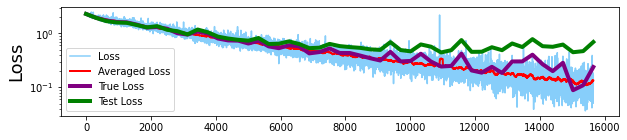

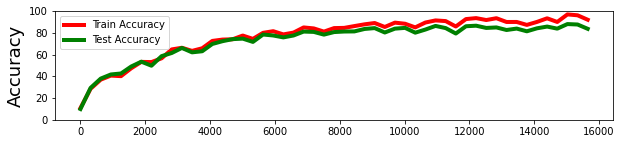

In [49]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="full(1)", bn_strategy="noBN", epochs=100)

all_stats['cifar', 'resnet34', 0, 0.02, 'full(1)', 'full(1)', 'noBN']
Total time: 2.44 h Final objective: 1.1021445 Final Train Accuracy: 61.242 Final Test Accuracy: 59.88


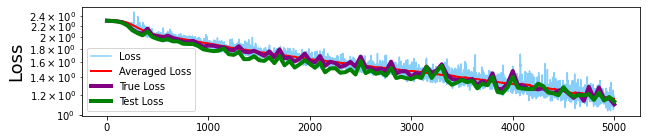

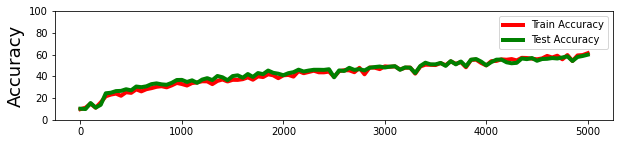

In [50]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="full(1)", bn_strategy="noBN", epochs=100)

all_stats['cifar', 'resnet34', 0, 0.1, 'full(1)', 'decr', 'noBN']
Total time: 5.18 h Final objective: 1.3693813 Final Train Accuracy: 55.972 Final Test Accuracy: 52.52


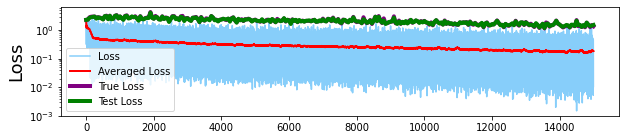

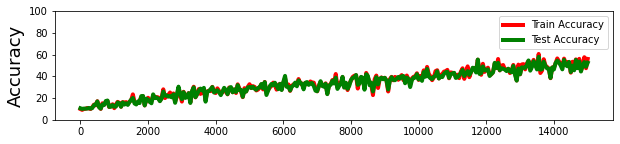

In [51]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="decr", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0, 0.02, 'full(1)', 'decr', 'noBN']
Total time: 4.13 h Final objective: 2.1272867 Final Train Accuracy: 34.24 Final Test Accuracy: 33.34


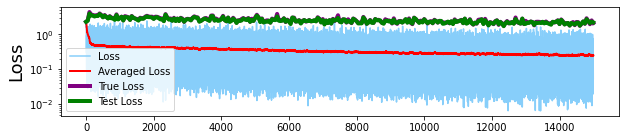

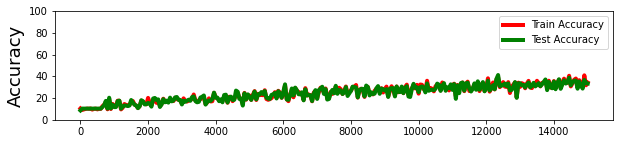

In [52]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="decr", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0, 0.1, 'full(1)', 'rand(0.2)', 'noBN']
Total time: 1.28 h Final objective: 1.7367296 Final Train Accuracy: 34.69 Final Test Accuracy: 38.2


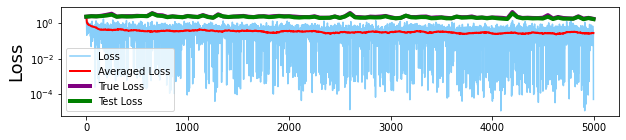

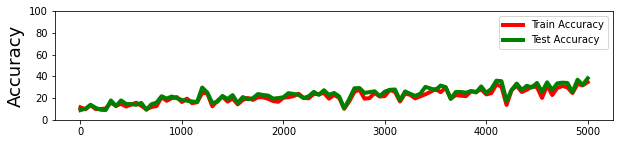

In [53]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0, 0.02, 'full(1)', 'rand(0.2)', 'noBN']
Total time: 3.45 h Final objective: 1.6309764 Final Train Accuracy: 40.53 Final Test Accuracy: 42.96


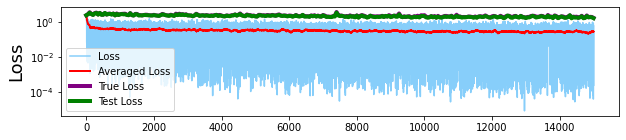

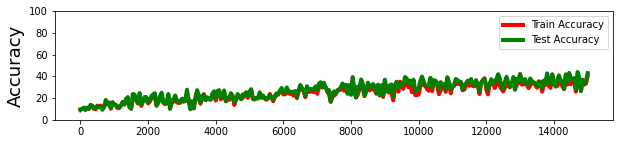

In [54]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0, 0.02, 'full(1)', 'full(25)', 'noBN']
Total time: 4.73 h Final objective: 1.9861 Final Train Accuracy: 28.14 Final Test Accuracy: 32.3


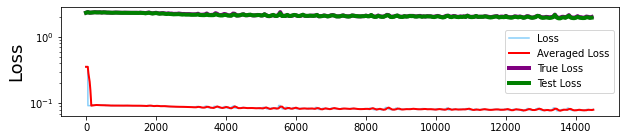

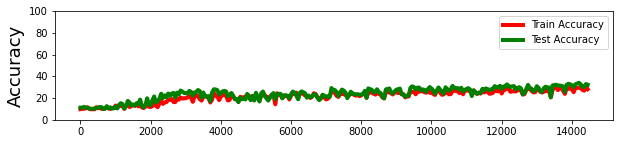

In [55]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="full(25)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0, 0.1, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 7.87 h Final objective: 2.008726 Final Train Accuracy: 28.046 Final Test Accuracy: 28.51


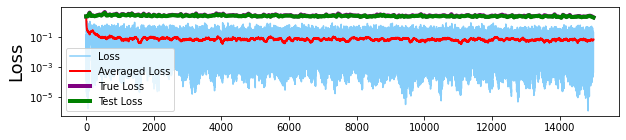

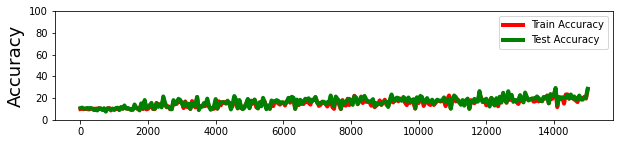

In [56]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0, 0.02, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 3.30 h Final objective: 3.2134943 Final Train Accuracy: 10.596 Final Test Accuracy: 11.51


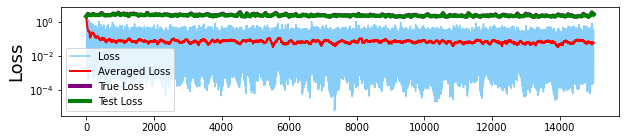

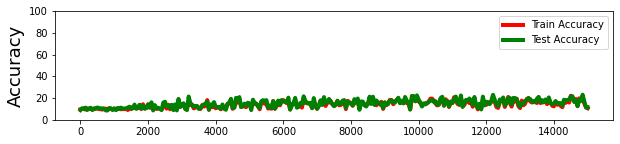

In [57]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


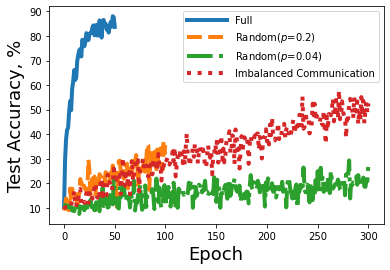

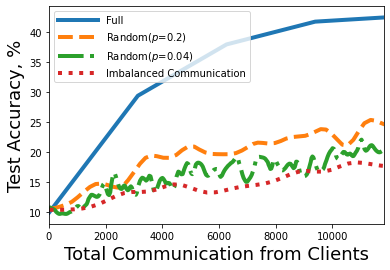

<Figure size 1296x36 with 0 Axes>

In [58]:
compare_stat([
              get('cifar', 'resnet34', 0, 0.1, 'full(1)', 'full(1)', 'noBN'),
              get('cifar', 'resnet34', 0, 0.1, 'full(1)', 'rand(0.2)', 'noBN'),
              get('cifar', 'resnet34', 0, 0.1, 'full(1)', 'rand(0.04)', 'noBN'),
              get('cifar', 'resnet34', 0, 0.1, 'full(1)', 'decr', 'noBN')
], ["Full", "Random($p$=0.2)", "Random($p$=0.04)", "Imbalanced Communication"],
  line_styles=["-", "--", "-.", ":"],
  smooth=True)

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


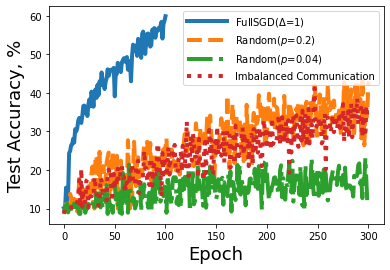

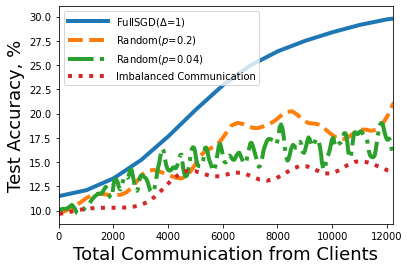

<Figure size 1296x36 with 0 Axes>

In [59]:
compare_stat([
              all_stats['cifar', 'resnet34', 0, 0.02, 'full(1)', 'full(1)', 'noBN'],
              all_stats['cifar', 'resnet34', 0, 0.02, 'full(1)', 'rand(0.2)', 'noBN'],
              all_stats['cifar', 'resnet34', 0, 0.02, 'full(1)', 'rand(0.04)', 'noBN'],
              all_stats['cifar', 'resnet34', 0, 0.02, 'full(1)', 'decr', 'noBN']
], ["FullSGD($\Delta$=1)", "Random($p$=0.2)", "Random($p$=0.04)", "Imbalanced Communication"],
  line_styles=["-", "--", "-.", ":"],
  smooth=True)

## MR 0.5

all_stats['cifar', 'resnet34', 0.5, 0.1, 'full(1)', 'full(1)', 'noBN']
Total time: 2.13 h Final objective: 0.10699291 Final Train Accuracy: 96.23 Final Test Accuracy: 87.75


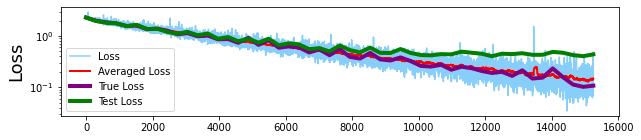

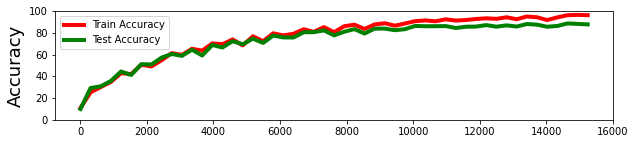

In [60]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0.5, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="full(1)", bn_strategy="noBN", epochs=100)

all_stats['cifar', 'resnet34', 0.5, 0.1, 'full(1)', 'rand(0.2)', 'noBN']
Total time: 2.02 h Final objective: 0.4934 Final Train Accuracy: 82.66 Final Test Accuracy: 79.7


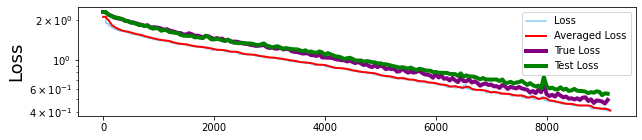

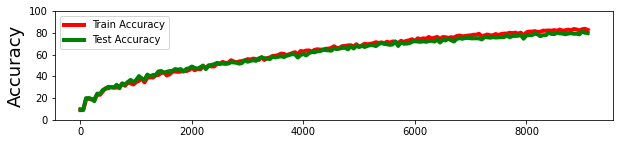

In [61]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0.5, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0.5, 0.1, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 2.48 h Final objective: 0.4411 Final Train Accuracy: 84.52 Final Test Accuracy: 81.6


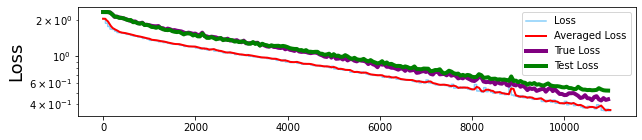

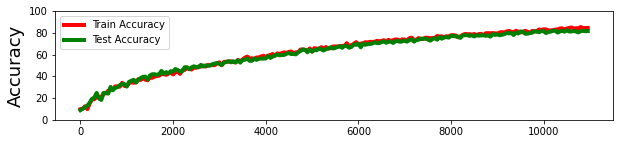

In [62]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0.5, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0.5, 0.1, 'full(1)', 'decr', 'noBN']
Total time: 2.48 h Final objective: 0.387 Final Train Accuracy: 86.02 Final Test Accuracy: 81.8


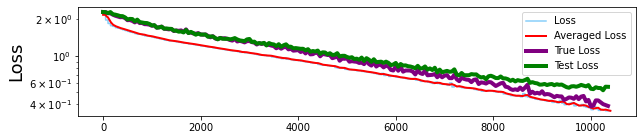

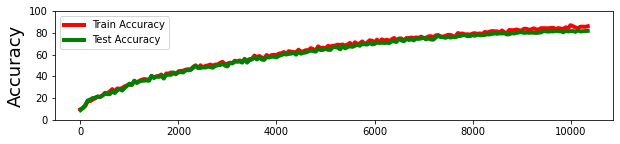

In [63]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0.5, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="decr", bn_strategy="noBN", epochs=300)

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


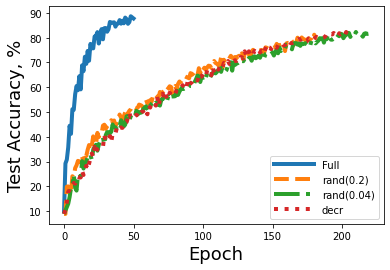

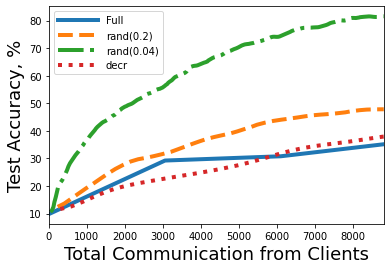

<Figure size 1296x36 with 0 Axes>

In [64]:
compare_stat([
              all_stats['cifar', 'resnet34', 0.5, 0.1, 'full(1)', 'full(1)', 'noBN'],
              all_stats['cifar', 'resnet34', 0.5, 0.1, 'full(1)', 'rand(0.2)', 'noBN'],
              all_stats['cifar', 'resnet34', 0.5, 0.1, 'full(1)', 'rand(0.04)', 'noBN'],
              all_stats['cifar', 'resnet34', 0.5, 0.1, 'full(1)', 'decr', 'noBN']
], ["Full", "rand(0.2)", "rand(0.04)", "decr"],
  line_styles=["-", "--", "-.", ":"],
  smooth=True)

## MR 0.1

all_stats['cifar', 'resnet34', 0.1, 0.1, 'full(1)', 'full(1)', 'noBN']
Total time: 1.92 h Final objective: 0.12056686 Final Train Accuracy: 95.696 Final Test Accuracy: 87.3


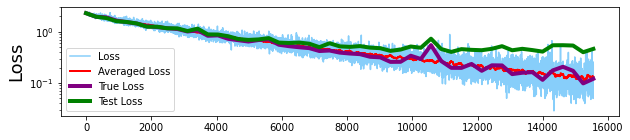

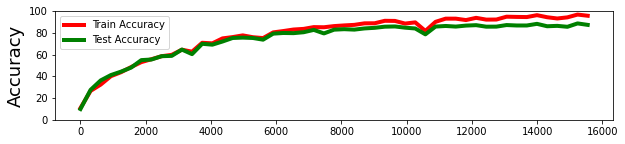

In [65]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0.1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="full(1)", bn_strategy="noBN", epochs=100)

all_stats['cifar', 'resnet34', 0.1, 0.1, 'full(1)', 'decr', 'noBN']
Total time: 6.29 h Final objective: 1.0442 Final Train Accuracy: 64.82 Final Test Accuracy: 63.1


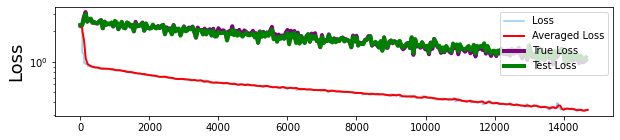

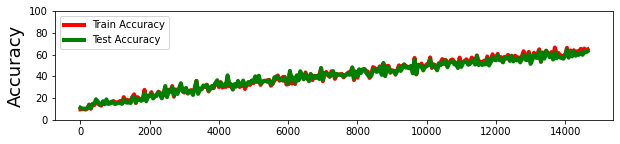

In [66]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0.1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="decr", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0.1, 0.1, 'full(1)', 'rand(0.2)', 'noBN']
Total time: 4.18 h Final objective: 0.94007295 Final Train Accuracy: 66.162 Final Test Accuracy: 63.62


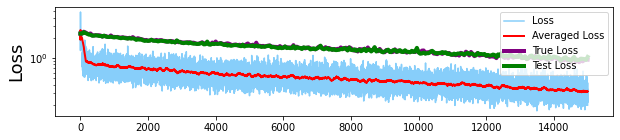

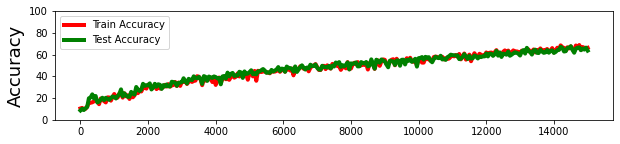

In [67]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0.1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0.1, 0.02, 'full(1)', 'rand(0.2)', 'noBN']
Total time: 3.65 h Final objective: 1.4095938 Final Train Accuracy: 48.156 Final Test Accuracy: 47.24


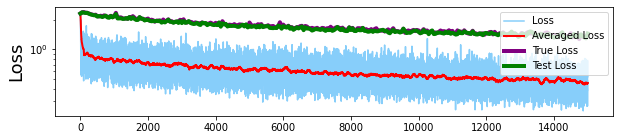

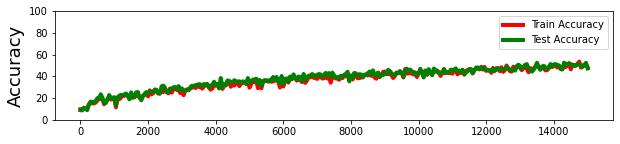

In [68]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0.1, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0.1, 0.1, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 6.47 h Final objective: 1.2534904 Final Train Accuracy: 53.038 Final Test Accuracy: 51.72


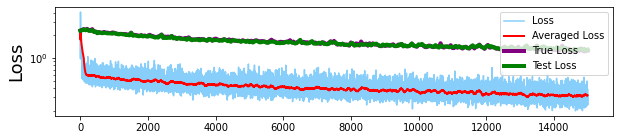

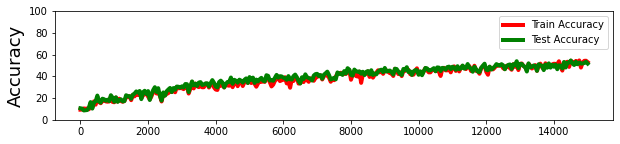

In [69]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0.1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'resnet34', 0.1, 0.02, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 3.30 h Final objective: 1.6337241 Final Train Accuracy: 38.16 Final Test Accuracy: 38.12


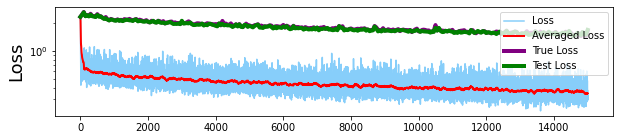

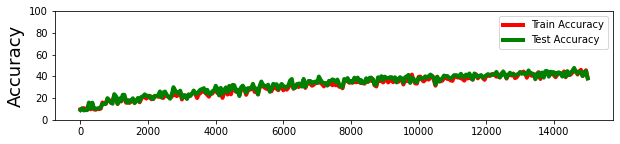

In [70]:
run_or_load(ds_name="cifar", model_name="resnet34", mixing_rate=0.1, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


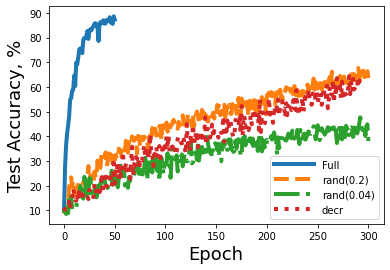

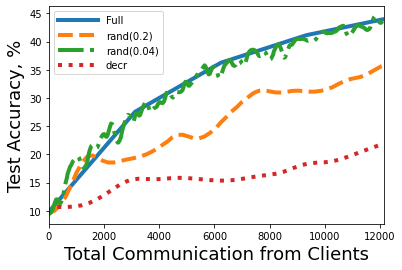

<Figure size 1296x36 with 0 Axes>

In [71]:
compare_stat([
              all_stats['cifar', 'resnet34', 0.1, 0.1, 'full(1)', 'full(1)', 'noBN'],
              all_stats['cifar', 'resnet34', 0.1, 0.1, 'full(1)', 'rand(0.2)', 'noBN'],
              all_stats['cifar', 'resnet34', 0.1, 0.02, 'full(1)', 'rand(0.04)', 'noBN'],
              all_stats['cifar', 'resnet34', 0.1, 0.1, 'full(1)', 'decr', 'noBN']
], ["Full", "rand(0.2)", "rand(0.04)", "decr"],
  line_styles=["-", "--", "-.", ":"],
  smooth=True)

In [72]:
# compare_stat([
#               all_stats['cifar', 'resnet34', 0.1, 0.02, 'full(1)', 'full(1)', 'noBN'],
#               all_stats['cifar', 'resnet34', 0.1, 0.02, 'full(1)', 'rand(0.2)', 'noBN'],
#               all_stats['cifar', 'resnet34', 0.1, 0.02, 'full(1)', 'rand(0.04)', 'noBN'],
#               all_stats['cifar', 'resnet34', 0.1, 0.02, 'full(1)', 'decr', 'noBN']
# ], ["Full", "rand(0.2)", "rand(0.04)", "decr"],
#   line_styles=["-", "--", "-.", ":"])

# VGG results

## MR 0

all_stats['cifar', 'vgg', 0, 0.1, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 2.48 h Final objective: 2.7177324 Final Train Accuracy: 15.328 Final Test Accuracy: 16.13


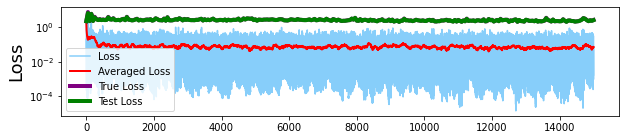

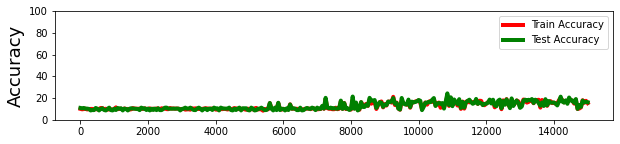

In [73]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'vgg', 0, 0.02, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 3.00 h Final objective: 2.2741373 Final Train Accuracy: 15.108 Final Test Accuracy: 15.24


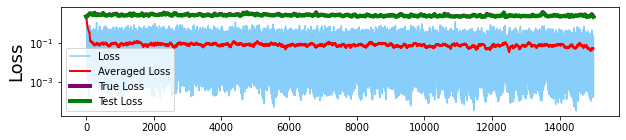

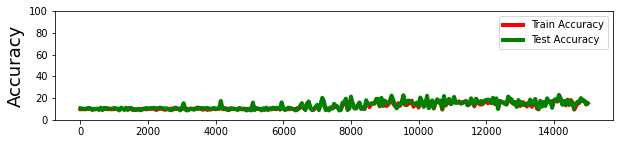

In [74]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'vgg', 0, 0.1, 'full(1)', 'rand(0.2)', 'noBN']
Total time: 2.74 h Final objective: 1.2306758 Final Train Accuracy: 58.142 Final Test Accuracy: 56.39


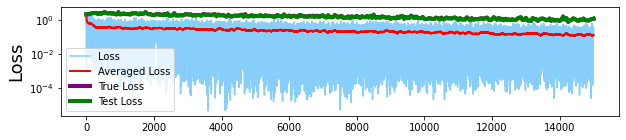

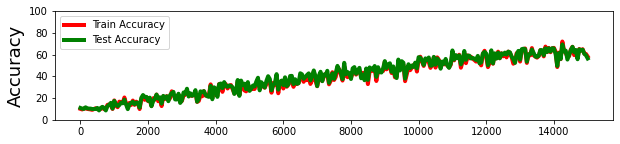

In [75]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'vgg', 0, 0.02, 'full(1)', 'rand(0.2)', 'noBN']
Total time: 3.28 h Final objective: 2.2519088 Final Train Accuracy: 27.726 Final Test Accuracy: 28.65


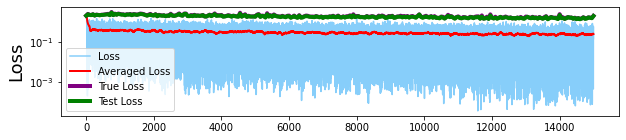

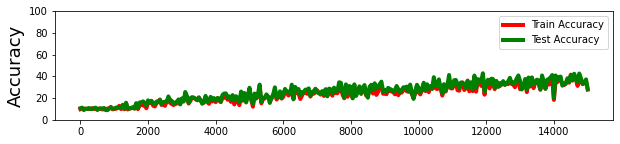

In [76]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

In [77]:
# run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="full(1)", bn_strategy="noBN", epochs=300)

## MR 0.1

In [78]:
# run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0.1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

In [79]:
# run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0.1, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

In [80]:
# run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0.1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

In [81]:
# run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0.1, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

In [82]:
# run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0.1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="decr", bn_strategy="noBN", epochs=300)

In [83]:
# run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0.1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="full(1)", bn_strategy="noBN", epochs=300)

## MR 0.5

all_stats['cifar', 'vgg', 0.5, 0.1, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 2.64 h Final objective: 0.1470151 Final Train Accuracy: 94.844 Final Test Accuracy: 85.02


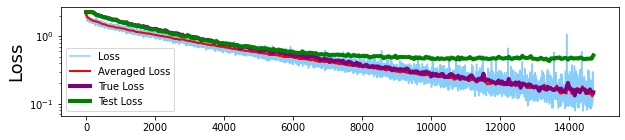

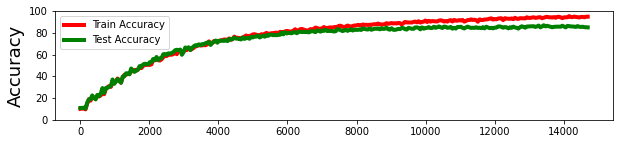

In [84]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0.5, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'vgg', 0.5, 0.02, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 3.20 h Final objective: 0.5389033 Final Train Accuracy: 80.932 Final Test Accuracy: 78.72


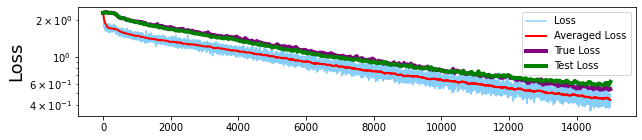

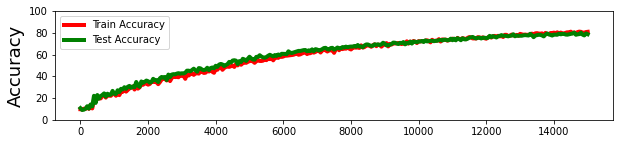

In [85]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0.5, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'vgg', 0.5, 0.02, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 3.20 h Final objective: 0.5389033 Final Train Accuracy: 80.932 Final Test Accuracy: 78.72


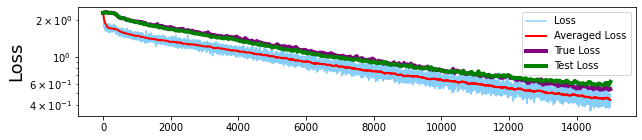

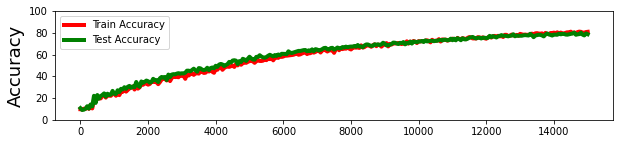

In [86]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0.5, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'vgg', 0.5, 0.02, 'full(1)', 'rand(0.2)', 'noBN']
Total time: 3.49 h Final objective: 0.4832853 Final Train Accuracy: 82.674 Final Test Accuracy: 79.99


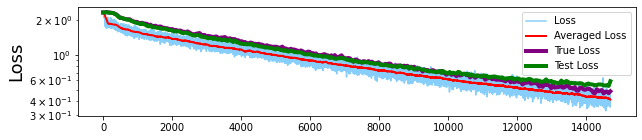

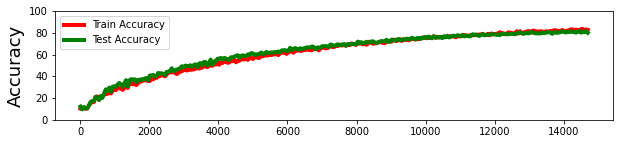

In [87]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=0.5, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

## MR 1

all_stats['cifar', 'vgg', 1, 0.1, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 1.85 h Final objective: 0.03356192 Final Train Accuracy: 98.97 Final Test Accuracy: 86.81


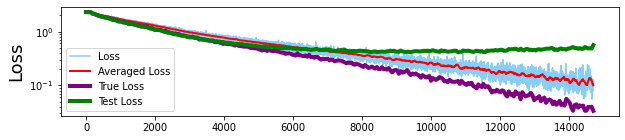

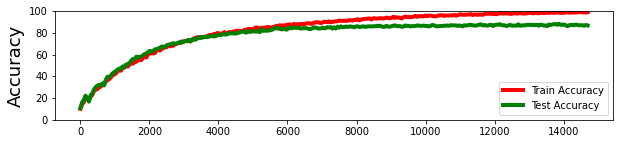

In [88]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'vgg', 1, 0.02, 'full(1)', 'rand(0.04)', 'noBN']
Total time: 2.27 h Final objective: 0.36109853 Final Train Accuracy: 87.564 Final Test Accuracy: 82.84


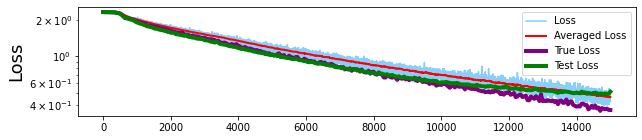

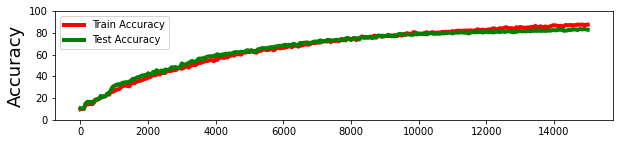

In [89]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=1, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.04)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'vgg', 1, 0.1, 'full(1)', 'rand(0.2)', 'noBN']
Total time: 2.34 h Final objective: 0.018312238 Final Train Accuracy: 99.482 Final Test Accuracy: 86.21


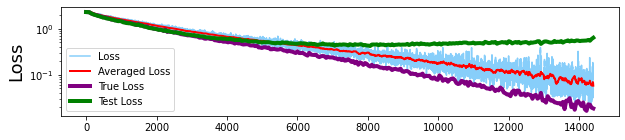

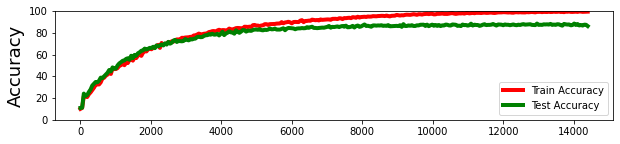

In [90]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'vgg', 1, 0.02, 'full(1)', 'rand(0.2)', 'noBN']
Total time: 2.38 h Final objective: 0.32590327 Final Train Accuracy: 88.752 Final Test Accuracy: 83.16


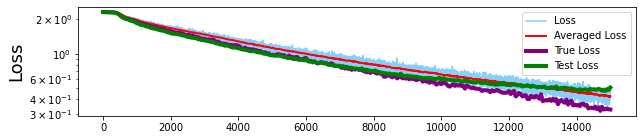

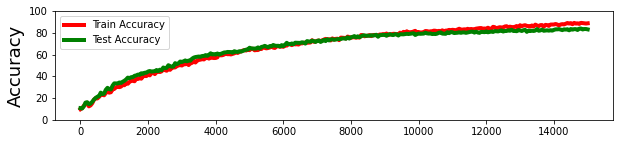

In [91]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=1, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="rand(0.2)", bn_strategy="noBN", epochs=300)

In [92]:
# run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=1, learning_rate=0.02, comp_strategy_type="full(1)", comm_strategy_type="full(1)", bn_strategy="noBN", epochs=300)

all_stats['cifar', 'vgg', 1, 0.1, 'full(1)', 'decr', 'noBN']
Total time: 2.42 h Final objective: 0.01379491 Final Train Accuracy: 99.572 Final Test Accuracy: 85.99


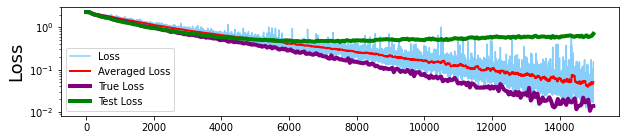

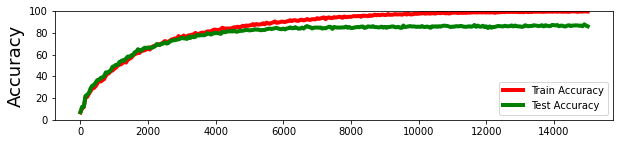

In [93]:
run_or_load(ds_name="cifar", model_name="vgg", mixing_rate=1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type="decr", bn_strategy="noBN", epochs=300)

# MNIST results

## MR 0

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


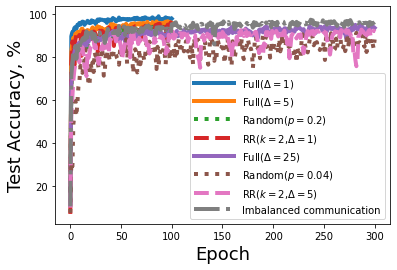

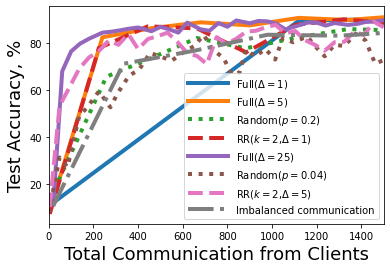

<Figure size 1296x36 with 0 Axes>

In [94]:
comm_strategy_types = ["full(1)", "full(5)", "rand(0.2)", "rr(2,1)", "full(25)", "rand(0.04)", "rr(2,5)", "decr"]
names = ["Full($\Delta=1$)", "Full($\Delta=5$)", "Random($p=0.2$)", "RR($k=2$,$\Delta=1$)", "Full($\Delta=25$)", "Random($p=0.04$)", "RR($k=2$,$\Delta=5$)", "Imbalanced communication"]
results = [get(ds_name="mnist", model_name="dense", mixing_rate=0, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type=comm_strategy_type, bn_strategy="noBN")
           for comm_strategy_type in comm_strategy_types]

line_styles = ["-", "-", ":", "--", "-", ":", "--", "-."]

compare_stat(results, names, line_styles, comm_lim=1500, smooth=False)

## MR 0.1

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


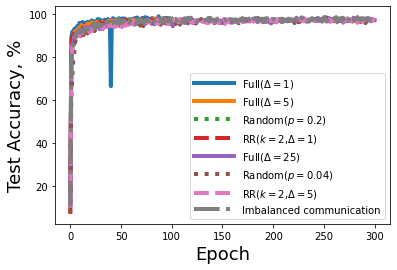

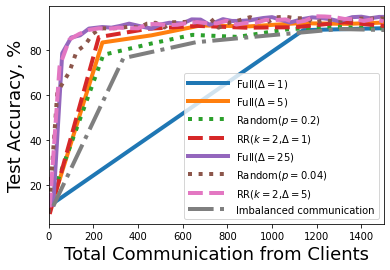

<Figure size 1296x36 with 0 Axes>

In [95]:
comm_strategy_types = ["full(1)", "full(5)", "rand(0.2)", "rr(2,1)", "full(25)", "rand(0.04)", "rr(2,5)", "decr"]
names = ["Full($\Delta=1$)", "Full($\Delta=5$)", "Random($p=0.2$)", "RR($k=2$,$\Delta=1$)", "Full($\Delta=25$)", "Random($p=0.04$)", "RR($k=2$,$\Delta=5$)", "Imbalanced communication"]
results = [get(ds_name="mnist", model_name="dense", mixing_rate=0.1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type=comm_strategy_type, bn_strategy="noBN")
           for comm_strategy_type in comm_strategy_types]

line_styles = ["-", "-", ":", "--", "-", ":", "--", "-."]

compare_stat(results, names, line_styles, comm_lim=1500, smooth=False)

## MR 0.5

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


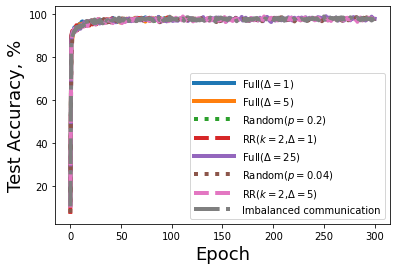

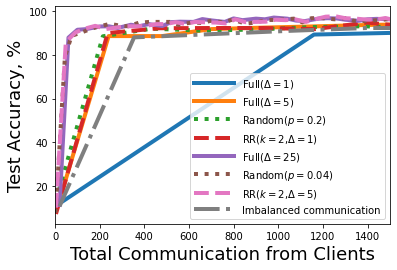

<Figure size 1296x36 with 0 Axes>

In [96]:
comm_strategy_types = ["full(1)", "full(5)", "rand(0.2)", "rr(2,1)", "full(25)", "rand(0.04)", "rr(2,5)", "decr"]
names = ["Full($\Delta=1$)", "Full($\Delta=5$)", "Random($p=0.2$)", "RR($k=2$,$\Delta=1$)", "Full($\Delta=25$)", "Random($p=0.04$)", "RR($k=2$,$\Delta=5$)", "Imbalanced communication"]
results = [get(ds_name="mnist", model_name="dense", mixing_rate=0.5, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type=comm_strategy_type, bn_strategy="noBN")
           for comm_strategy_type in comm_strategy_types]

line_styles = ["-", "-", ":", "--", "-", ":", "--", "-."]

compare_stat(results, names, line_styles, comm_lim=1500, smooth=False)

## MR 1

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


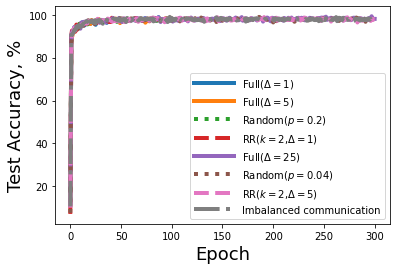

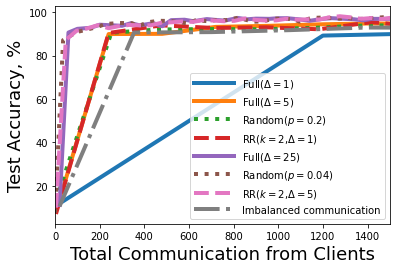

<Figure size 1296x36 with 0 Axes>

In [97]:
comm_strategy_types = ["full(1)", "full(5)", "rand(0.2)", "rr(2,1)", "full(25)", "rand(0.04)", "rr(2,5)", "decr"]
names = ["Full($\Delta=1$)", "Full($\Delta=5$)", "Random($p=0.2$)", "RR($k=2$,$\Delta=1$)", "Full($\Delta=25$)", "Random($p=0.04$)", "RR($k=2$,$\Delta=5$)", "Imbalanced communication"]
results = [get(ds_name="mnist", model_name="dense", mixing_rate=1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type=comm_strategy_type, bn_strategy="noBN")
           for comm_strategy_type in comm_strategy_types]

line_styles = ["-", "-", ":", "--", "-", ":", "--", "-."]

compare_stat(results, names, line_styles, comm_lim=1500, smooth=False)

# Fashion-MNIST results

## MR 0

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


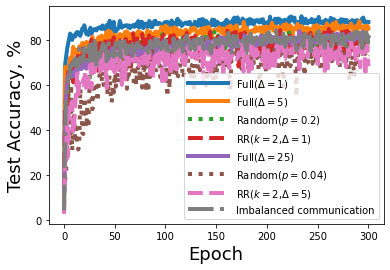

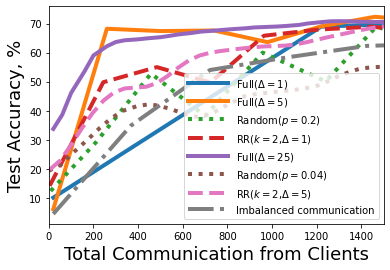

<Figure size 1296x36 with 0 Axes>

In [98]:
comm_strategy_types = ["full(1)", "full(5)", "rand(0.2)", "rr(2,1)", "full(25)", "rand(0.04)", "rr(2,5)", "decr"]
names = ["Full($\Delta=1$)", "Full($\Delta=5$)", "Random($p=0.2$)", "RR($k=2$,$\Delta=1$)", "Full($\Delta=25$)", "Random($p=0.04$)", "RR($k=2$,$\Delta=5$)", "Imbalanced communication"]
results = [get(ds_name="fashion", model_name="dense", mixing_rate=0, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type=comm_strategy_type, bn_strategy="noBN")
           for comm_strategy_type in comm_strategy_types]

line_styles = ["-", "-", ":", "--", "-", ":", "--", "-."]

compare_stat(results, names, line_styles, comm_lim=1500, smooth=True)

## MR 0.1

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


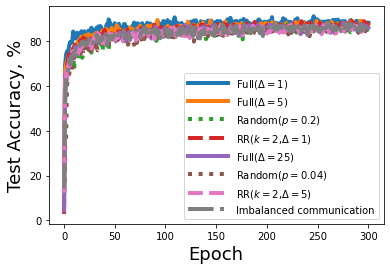

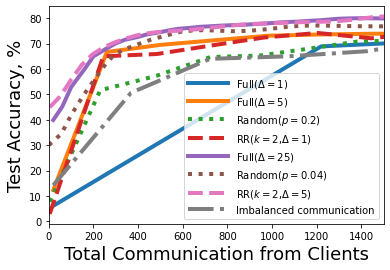

<Figure size 1296x36 with 0 Axes>

In [99]:
comm_strategy_types = ["full(1)", "full(5)", "rand(0.2)", "rr(2,1)", "full(25)", "rand(0.04)", "rr(2,5)", "decr"]
names = ["Full($\Delta=1$)", "Full($\Delta=5$)", "Random($p=0.2$)", "RR($k=2$,$\Delta=1$)", "Full($\Delta=25$)", "Random($p=0.04$)", "RR($k=2$,$\Delta=5$)", "Imbalanced communication"]
results = [get(ds_name="fashion", model_name="dense", mixing_rate=0.1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type=comm_strategy_type, bn_strategy="noBN")
           for comm_strategy_type in comm_strategy_types]

line_styles = ["-", "-", ":", "--", "-", ":", "--", "-."]

compare_stat(results, names, line_styles, comm_lim=1500, smooth=True)

## MR 0.5

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


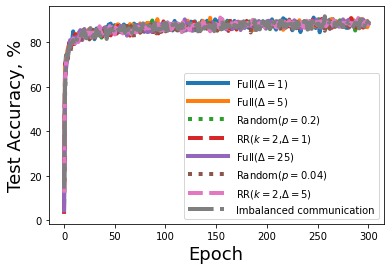

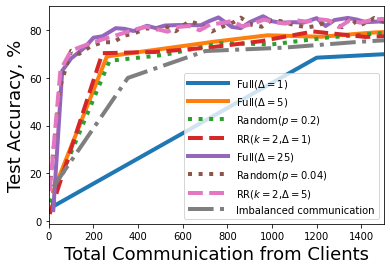

<Figure size 1296x36 with 0 Axes>

In [100]:
comm_strategy_types = ["full(1)", "full(5)", "rand(0.2)", "rr(2,1)", "full(25)", "rand(0.04)", "rr(2,5)", "decr"]
names = ["Full($\Delta=1$)", "Full($\Delta=5$)", "Random($p=0.2$)", "RR($k=2$,$\Delta=1$)", "Full($\Delta=25$)", "Random($p=0.04$)", "RR($k=2$,$\Delta=5$)", "Imbalanced communication"]
results = [get(ds_name="fashion", model_name="dense", mixing_rate=0.5, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type=comm_strategy_type, bn_strategy="noBN")
           for comm_strategy_type in comm_strategy_types]

line_styles = ["-", "-", ":", "--", "-", ":", "--", "-."]

compare_stat(results, names, line_styles, comm_lim=1500, smooth=False)

## MR 1

<ipython-input-47-fff94ad93cf9>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


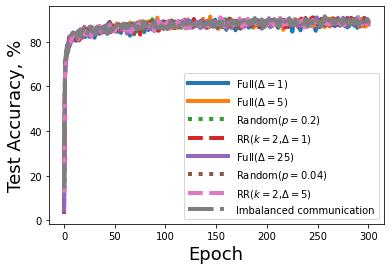

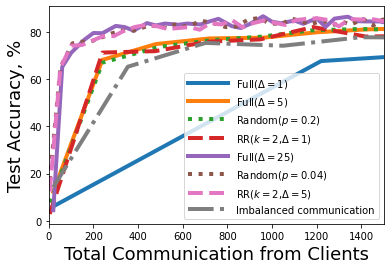

<Figure size 1296x36 with 0 Axes>

In [101]:
comm_strategy_types = ["full(1)", "full(5)", "rand(0.2)", "rr(2,1)", "full(25)", "rand(0.04)", "rr(2,5)", "decr"]
names = ["Full($\Delta=1$)", "Full($\Delta=5$)", "Random($p=0.2$)", "RR($k=2$,$\Delta=1$)", "Full($\Delta=25$)", "Random($p=0.04$)", "RR($k=2$,$\Delta=5$)", "Imbalanced communication"]
results = [get(ds_name="fashion", model_name="dense", mixing_rate=1, learning_rate=0.1, comp_strategy_type="full(1)", comm_strategy_type=comm_strategy_type, bn_strategy="noBN")
           for comm_strategy_type in comm_strategy_types]

line_styles = ["-", "-", ":", "--", "-", ":", "--", "-."]

compare_stat(results, names, line_styles, comm_lim=1500, smooth=False)